Taxi Availability Prediction with Meta-Ensemble

This notebook implements a two-layer ensemble: RandomForest and XGBoost base learners whose predictions are fed into a final XGBoost meta-learner.

1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import random
import joblib

2. Data Loading & Preprocessing

In [2]:
# Load data
df = pd.read_csv("merged_file_with_mean.csv")

# Time-based features
df["DateTime"] = pd.to_datetime(df["DateTime"])
df["IsWeekend"] = (df["DateTime"].dt.weekday >= 5).astype(int)
df["Hour"] = df["DateTime"].dt.hour + 1  # 1 to 24
df["DayOfWeek"] = df["DateTime"].dt.dayofweek

# Drop unnecessary columns
df = df.drop(columns=["DateTime", "stationId", "Coordinates[]", "Group"])

# Add lag features for past 3 hours
lag_features = ["Average Taxi Availability", "Taxi Available throughout SG", "temp_value" ,"humidity_value"]  
for lag in range(1, 4):  
    for col in lag_features:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# Create multi-step ahead targets
df["target_t1"] = df["Average Taxi Availability"].shift(-1)
df["target_t2"] = df["Average Taxi Availability"].shift(-2)
df["target_t3"] = df["Average Taxi Availability"].shift(-3)

# Drop NaNs caused by shift (front and back)
df = df.dropna().reset_index(drop=True)

# Split features and targets
target_cols = ["target_t1", "target_t2", "target_t3"]
y = df[target_cols].values
X = df.drop(columns=target_cols).values

# Normalize features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Train/Validation/Test split (80/10/10)
random_state = 23
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

# Print diagnostics
print("Feature matrix shape:", X.shape)
print("Target matrix shape:", y.shape)
print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])


feature_columns = df.drop(columns=["target_t1", "target_t2", "target_t3"]).columns.tolist()
X_train_df = pd.DataFrame(X_train, columns=feature_columns)
X_test_df = pd.DataFrame(X_test, columns=feature_columns)
y_train_df = pd.DataFrame(y_train, columns=["target_t1", "target_t2", "target_t3"])
y_test_df = pd.DataFrame(y_test, columns=["target_t1", "target_t2", "target_t3"])

print("\n First few rows of X_train:")
print(X_train_df.head())

print("\n First few rows of y_train:")
print(y_train_df.head())

print("\n First few rows of X_test:")
print(X_test_df.head())

print("\n First few rows of y_test:")
print(y_test_df.head())



Feature matrix shape: (25585, 22)
Target matrix shape: (25585, 3)
Train size: 20468
Validation size: 2558
Test size: 2559

 First few rows of X_train:
   Taxi Available throughout SG  Taxi Available in Selected Box Area  \
0                      0.447609                             0.281369   
1                      0.250134                             0.224335   
2                      0.508866                             0.368821   
3                      0.482805                             0.307985   
4                      0.518538                             0.425856   

   temp_value  humidity_value  rainfall_value  peak_period  \
0    0.842085        0.798758             0.0          0.0   
1    0.842085        0.798758             0.0          0.0   
2    0.872781        0.848731             0.0          0.0   
3    0.842085        0.798758             0.0          0.0   
4    0.842085        0.798758             0.0          0.0   

   Average Taxi Availability  IsWeekend    

3. Base Learner Out‑of‑Fold Predictions

In [3]:
# Set number of splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Storage for OOF predictions (same shape as y_train)
oof_preds_rf  = np.zeros((X_train.shape[0], 3))
oof_preds_xgb = np.zeros((X_train.shape[0], 3))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n Fold {fold+1}/{n_splits}")

    # Split training into inner-train and inner-validation
    X_tr, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_tr, y_val_fold = y_train[train_idx], y_train[val_idx]

    # RandomForest Regressor as MultiOutput
    rf_model = MultiOutputRegressor(RandomForestRegressor(
        n_estimators=100, random_state=random_state, n_jobs=-1
    ))
    rf_model.fit(X_tr, y_tr)
    rf_preds = rf_model.predict(X_val_fold)
    oof_preds_rf[val_idx] = rf_preds
    print("RF fold MAE:", np.mean(np.abs(rf_preds - y_val_fold)))

    # XGBoost Regressor as MultiOutput 
    xgb_model = MultiOutputRegressor(xgb.XGBRegressor(
        n_estimators=100, learning_rate=0.1, random_state=random_state, verbosity=0, n_jobs=-1
    ))
    xgb_model.fit(X_tr, y_tr)
    xgb_preds = xgb_model.predict(X_val_fold)
    oof_preds_xgb[val_idx] = xgb_preds
    print("XGB fold MAE:", np.mean(np.abs(xgb_preds - y_val_fold)))

print(oof_preds_rf.shape)
print(oof_preds_xgb.shape)



 Fold 1/5
RF fold MAE: 11.029514601313577
XGB fold MAE: 10.725941832055359

 Fold 2/5
RF fold MAE: 10.825553642186396
XGB fold MAE: 10.567755281462548

 Fold 3/5
RF fold MAE: 11.103942042555502
XGB fold MAE: 10.855357887904988

 Fold 4/5
RF fold MAE: 10.885947878491734
XGB fold MAE: 10.529397237803444

 Fold 5/5
RF fold MAE: 10.721988231940712
XGB fold MAE: 10.390235393692034
(20468, 3)
(20468, 3)


4. Train Meta‑Learner XGBoost

In [4]:
# Stack OOF base learner predictions for training meta-learner
# Each: shape = (n_samples, 3) → after hstack: (n_samples, 6)
oof_meta_features = np.hstack([oof_preds_rf, oof_preds_xgb])

# Train meta-learner on these OOF features and original targets
meta = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state, verbosity=0)
meta.fit(oof_meta_features, y_train)

# Generate predictions from base models on validation set
val_preds_rf  = rf_model.predict(X_val)
val_preds_xgb = xgb_model.predict(X_val)

# Stack validation base predictions for meta input
val_meta_input = np.hstack([val_preds_rf, val_preds_xgb])

# Meta-learner makes final prediction
y_pred_val = meta.predict(val_meta_input)

# Evaluate performance
mse_meta = mean_squared_error(y_val, y_pred_val)
mae_meta = mean_absolute_error(y_val, y_pred_val)

print("MSE :", mse_meta)
print("MAE :", mae_meta)


MSE : 214.58930524554262
MAE : 10.52965663838331


5. Final Test Set Evaluation

In [5]:
# Retrain base learners on full training data using MultiOutputRegressor
rf_full_model = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=100, random_state=random_state, n_jobs=-1
)).fit(X_train, y_train)

xgb_full_model = MultiOutputRegressor(xgb.XGBRegressor(
    n_estimators=100, learning_rate=0.1, random_state=random_state, verbosity=0, n_jobs=-1
)).fit(X_train, y_train)

# Generate predictions on test set from base models
test_preds_rf  = rf_full_model.predict(X_test)     # shape: (n_test, 3)
test_preds_xgb = xgb_full_model.predict(X_test)    # shape: (n_test, 3)

# Stack predictions horizontally for meta-learner input
X_test_meta = np.hstack([test_preds_rf, test_preds_xgb])  # shape: (n_test, 6)

# Predict final output using meta-learner
y_pred_test = meta.predict(X_test_meta)  # shape: (n_test, 3)

# Evaluate performance
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("MSE :", mse_test)
print("MAE :", mae_test)

# Compare predicted vs actual values for first few test samples
for i in range(5):
    print(f"Predicted: {np.round(y_pred_test[i], 2)}   |   Actual: {np.round(y_test[i], 2)}")


MSE : 216.8705381523777
MAE : 10.447990680754392
Predicted: [ 96.57 107.08 124.13]   |   Actual: [ 95.17 112.25 127.  ]
Predicted: [108.64 108.63 108.63]   |   Actual: [ 98.58 101.67  97.08]
Predicted: [ 98.04 106.88 104.56]   |   Actual: [107.08 111.83  89.33]
Predicted: [22.97 23.91 24.83]   |   Actual: [21.67 19.58 18.58]
Predicted: [46.63 45.88 46.54]   |   Actual: [31.25 29.17 33.92]


In [6]:
#Save
joblib.dump(rf_full_model, "Ensemble_RF.pth")
joblib.dump(xgb_full_model, "Ensemble_XGB.pth")
joblib.dump(meta, "Ensemble_Meta.pth")

['Ensemble_Meta.pth']

In [7]:
#Load
rf_full_model = joblib.load("Ensemble_RF.pth")
xgb_full_model = joblib.load("Ensemble_XGB.pth")
meta = joblib.load("Ensemble_Meta.pth")

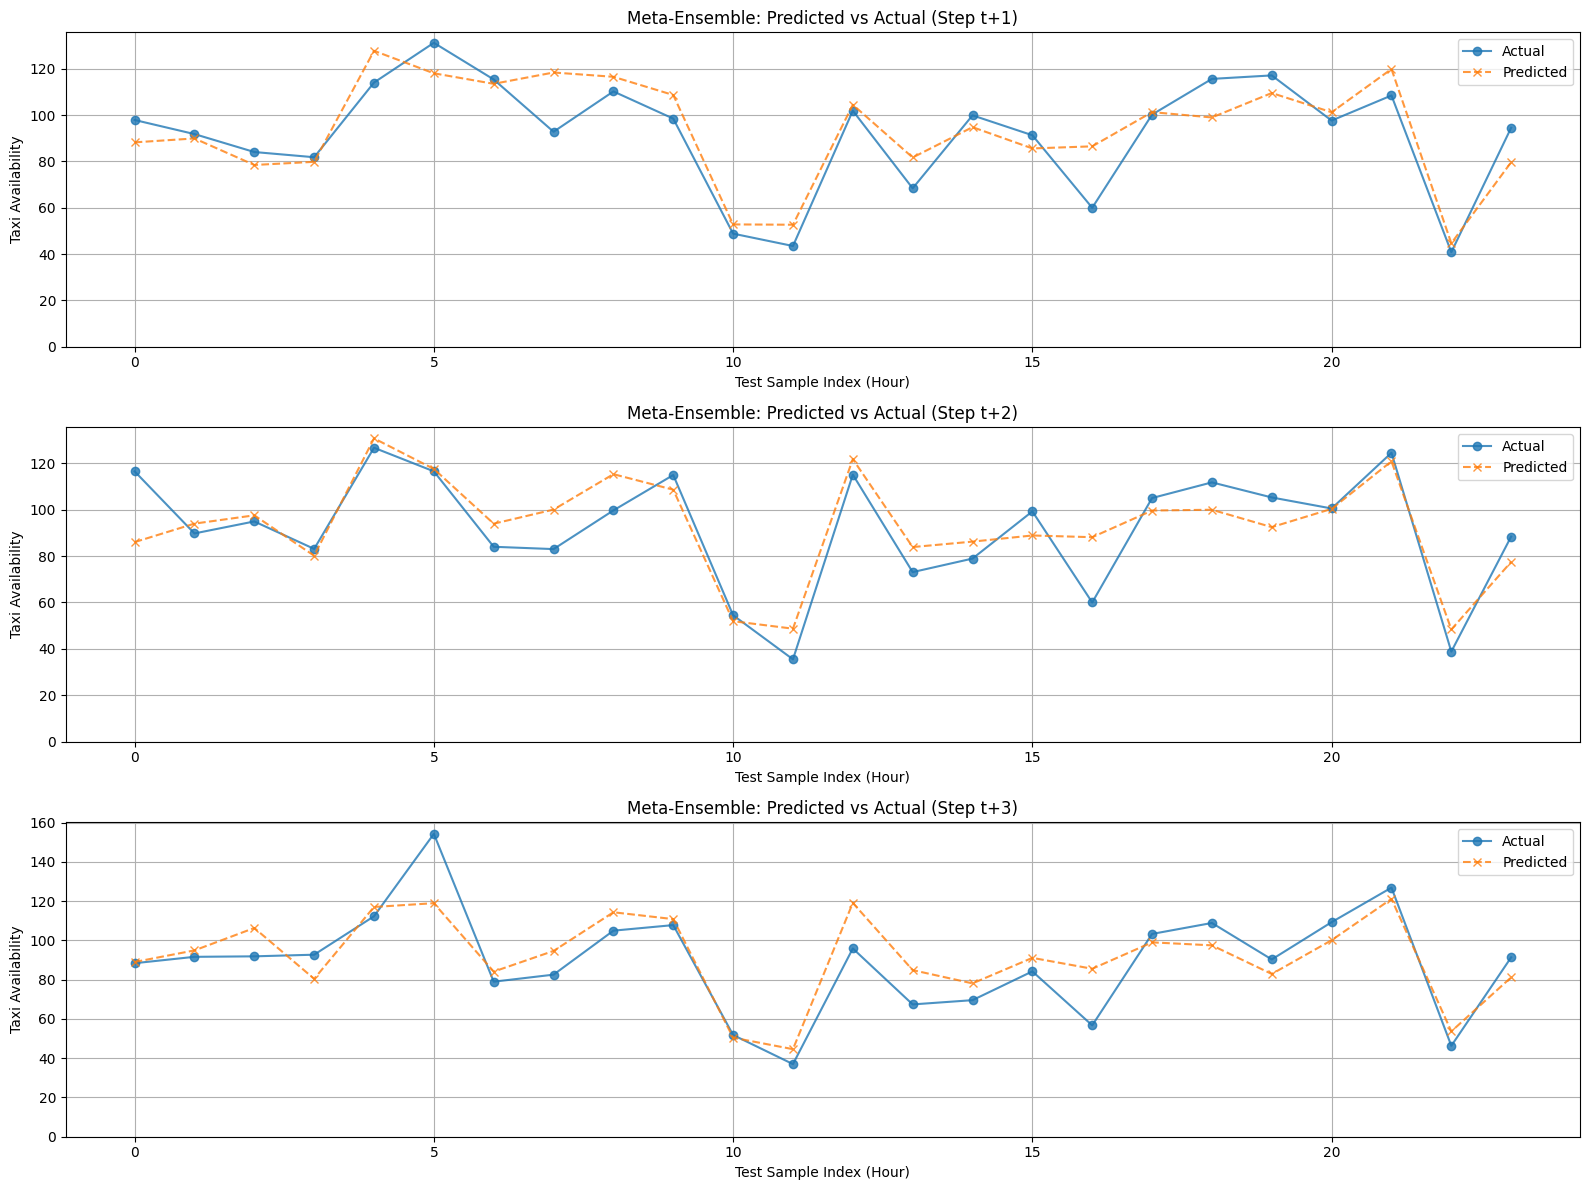

In [8]:
# Pick a random start index (multiple of 24 for a day-based slice)
n_points = random.choice(range(0, len(y_test) - 24, 24))
end = n_points + 24

# Plot for each forecast step: t+1, t+2, t+3
plt.figure(figsize=(16, 12))

forecast_steps = ["t+1", "t+2", "t+3"]
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(y_test[n_points:end, i], label="Actual", marker='o', linestyle='-', alpha=0.8)
    plt.plot(y_pred_test[n_points:end, i], label="Predicted", marker='x', linestyle='--', alpha=0.8)
    plt.xlabel("Test Sample Index (Hour)")
    plt.ylabel("Taxi Availability")
    plt.title(f"Meta-Ensemble: Predicted vs Actual (Step {forecast_steps[i]})")
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0)

plt.tight_layout()
plt.show()